In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [53]:
ori_df = pd.read_csv('../../traces/MSR-Cambridge2/CAMRESSDPA01-lvm0.csv', header=None)
ori_df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
ori_df['Timestamp'] = ori_df['Timestamp'].astype(np.int64)
ori_df = ori_df.sort_values(by='Timestamp')
ori_df.head()
#df.tail()

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime
0,128166373321652068,src1,0,Write,3173167104,36864,3126
1,128166373321653856,src1,0,Write,3154128896,4096,1337
2,128166373321653876,src1,0,Write,3154132992,4096,1318
3,128166373371652876,src1,0,Write,3744964608,4096,1998
4,128166373421651545,src1,0,Write,3173203968,32768,3009


In [55]:
print(ori_df['Hostname'].value_counts())
print(ori_df['DiskNumber'].value_counts())
ori_req_num = ori_df['Timestamp'].count()
ori_req_num

src1    37415613
Name: Hostname, dtype: int64
0    37415613
Name: DiskNumber, dtype: int64


37415613

In [56]:
total_size = ori_df.drop_duplicates(['Offset'])['Size'].sum()
total_size

164910662144

In [59]:
# Take first 10% of the trace
sample_num = int(ori_req_num * 0.2)
df = ori_df.head(sample_num)

In [60]:
req_num = df['Timestamp'].count()
req_num

7483122

In [61]:
total_size = df.drop_duplicates(['Offset'])['Size'].sum()
total_size

148790469120

In [62]:
workload_of_caches = [0, 0, 0, 0]
for row in df.drop_duplicates(['Offset']).itertuples():
    workload_of_caches[(getattr(row, 'Offset') // 10000 % 1000000) & 0b11111 % 4] += 1
workload_of_caches        # 检验哈希函数合理性

[1091030, 1084577, 1084343, 1084474]

In [63]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [64]:
class Server:                                       # 服务器(cache)
    def __init__(self, space):
        self.space = space                          # cache大小
        self.remain = space                         # cache剩余空间
        self.cache = OrderedDict()                  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0                          # 命中次数
        self.bite_hit_count = 0
        self.miss_count = 0                         # 未命中次数
        self.bite_miss_count = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.bite_hit_count += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.bite_miss_count += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):                         # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
            #return 1
        else:
            self._miss(fid, size)
            #return 0

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"
    
    def bite_hit_rate(self):
        try:
            return self.bite_hit_count / (self.bite_hit_count + self.bite_miss_count)
        except:
            return "Server has not been requested yet!"

In [65]:
class Dispatcher:
    def __init__(self, file_number, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row,'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number
        
    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[self.file_mapper[fid]] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.big_cache.handle(fid, size)
        
    def simple_hash(self, fid, size):
        self.big_cache.handle(fid, size)
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [66]:
FILE_NUM = len(df['Offset'].value_counts())
CACHE_NUMBER = 4
print(FILE_NUM)
print(CACHE_NUMBER)

4344424
4


In [67]:
small_server_hit_rate = []
small_server_hit_number = []
small_server_hit_ratio = []
small_server_hit_ratio_syn = []
big_server_hit_rate = []
big_server_hit_number = []
big_server_hit_ratio = []
big_server_hit_ratio_syn = []

cache_size_array = []
for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
    cache_size_array.append(cache_size / total_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER)
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
    small_server_hit_rate.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    small_server_hit_ratio.append((sum([i.hit_count for i in hash_dispatcher.small_caches]))/req_num)
    big_server_hit_rate.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number.append(hash_dispatcher.big_cache.hit_count)
    big_server_hit_ratio.append((sum([i.hit_count for i in hash_dispatcher.small_caches]))/req_num)

7483122

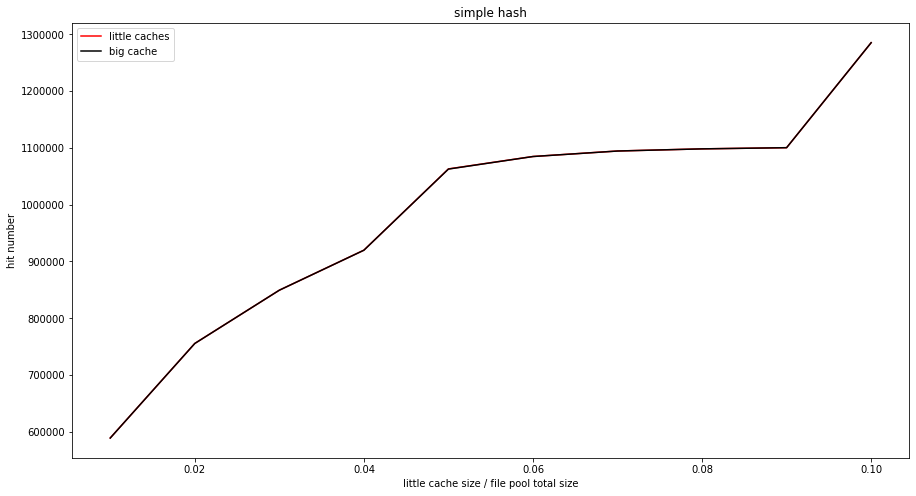

In [68]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array, small_server_hit_number, color='red', label='little caches')
plt.plot(cache_size_array, big_server_hit_number, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("simple hash")
plt.legend()
#small_server_hit_ratio
df.tail()
#print(df['Hostname'].value_counts())
#df['Hostname'].value_counts()
df['Hostname'].count()

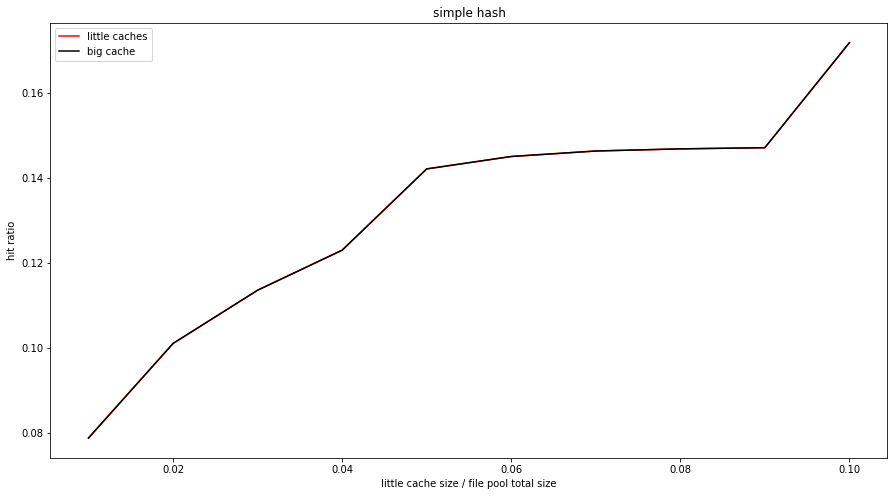

In [69]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array, small_server_hit_ratio, color='red', label='little caches')
plt.plot(cache_size_array, big_server_hit_ratio, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit ratio")
plt.title("simple hash")
plt.legend()

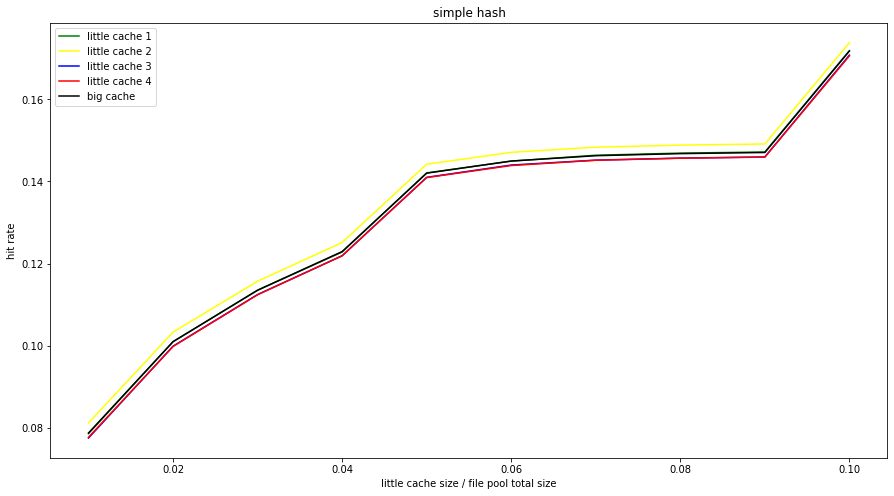

In [70]:
colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array, [j[i] for j in small_server_hit_rate], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array, big_server_hit_rate, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("simple hash")
plt.legend()

In [71]:
small_server_hit_rate_ = []
small_server_hit_number_ = []
small_server_hit_ratio_ = []
small_server_hit_ratio_syn_ = []
big_server_hit_rate_ = []
big_server_hit_number_ = []
big_server_hit_ratio_ = []
big_server_hit_ratio_syn_ = []

cache_size_array_ = []
for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
    cache_size_array_.append(cache_size / total_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER, False)
    cur_req = 0
    sub_big_server_hit_ratio_syn_ = []
    sub_small_server_hit_ratio_syn_ = []
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
        
        
        cur_req += 1
        
        sub_big_server_hit_ratio_syn_.append(hash_dispatcher.big_cache.hit_count/cur_req)
        sub_small_server_hit_ratio_syn_.append(sum([i.hit_count for i in hash_dispatcher.small_caches])/cur_req)
        
    big_server_hit_ratio_syn_.append(sub_big_server_hit_ratio_syn_)
    small_server_hit_ratio_syn_.append(sub_small_server_hit_ratio_syn_)
        
    small_server_hit_rate_.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number_.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    small_server_hit_ratio_.append(sum([i.hit_count for i in hash_dispatcher.small_caches])/req_num)
    big_server_hit_rate_.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number_.append(hash_dispatcher.big_cache.hit_count)
    big_server_hit_ratio_.append(hash_dispatcher.big_cache.hit_count/req_num)

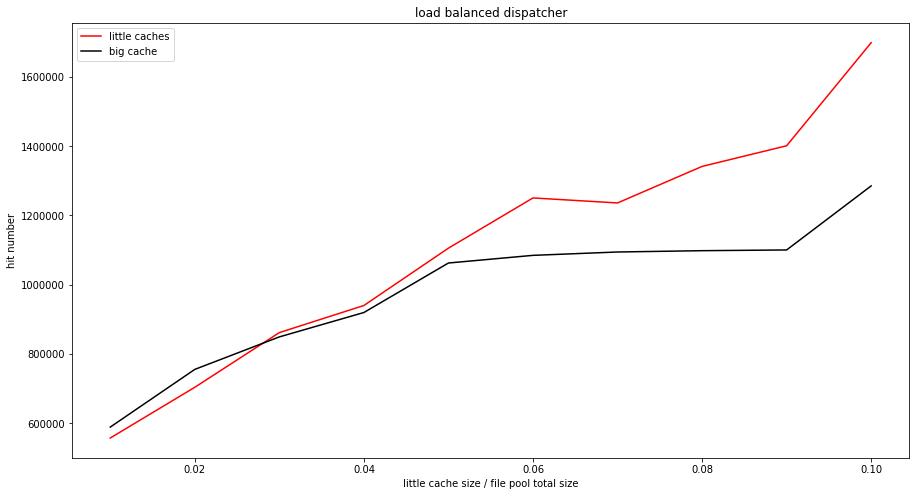

In [72]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_number_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_number_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

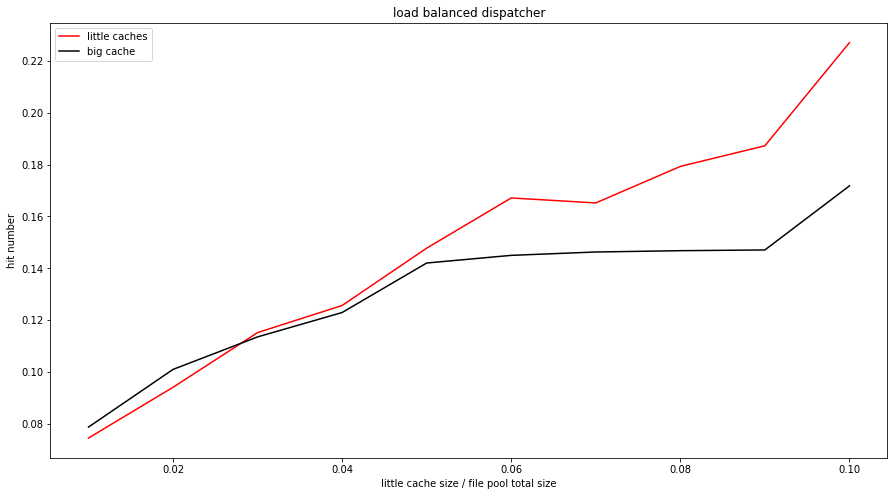

In [73]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_ratio_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_ratio_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

/home/ovs3/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ovs3/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


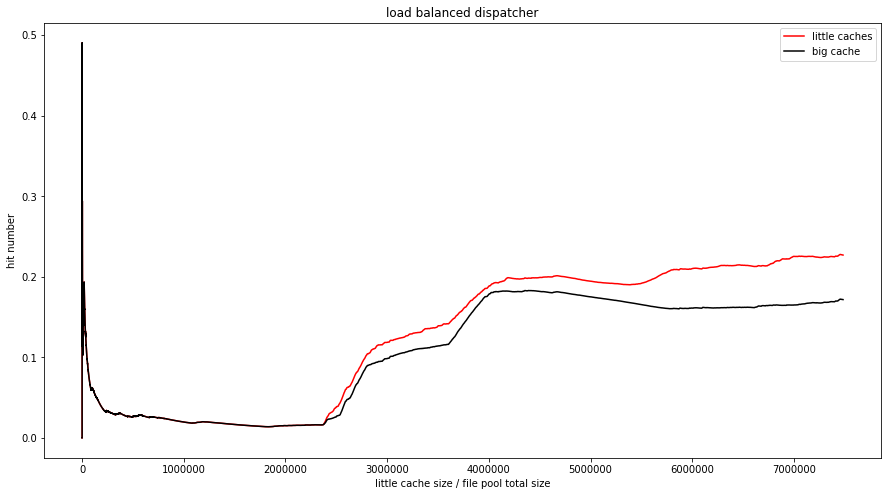

In [74]:
plt.figure(figsize=(15,8))
plt.plot(range(len(small_server_hit_ratio_syn_[7])), small_server_hit_ratio_syn_[9], color='red', label='little caches')
plt.plot(range(len(big_server_hit_ratio_syn_[7])), big_server_hit_ratio_syn_[9], color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

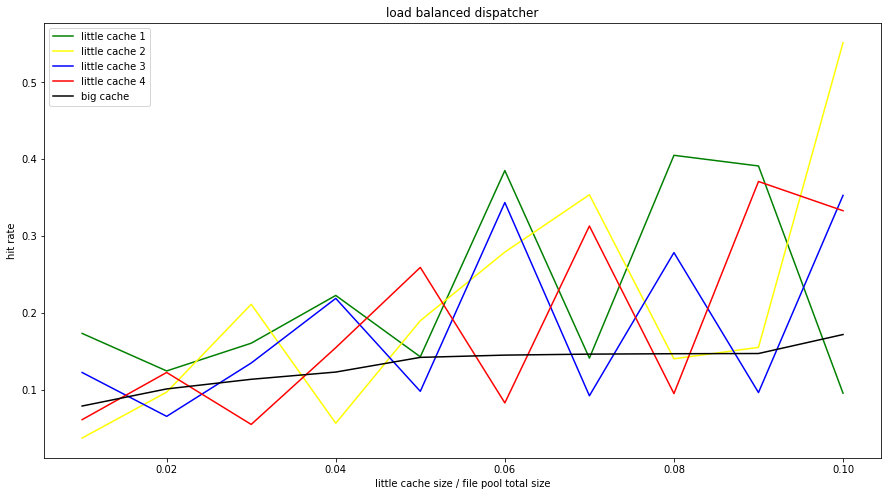

In [75]:
colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array_, [j[i] for j in small_server_hit_rate_], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array_, big_server_hit_rate_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("load balanced dispatcher")
plt.legend()

In [76]:
x = df['Offset'].value_counts().values

No handles with labels found to put in legend.


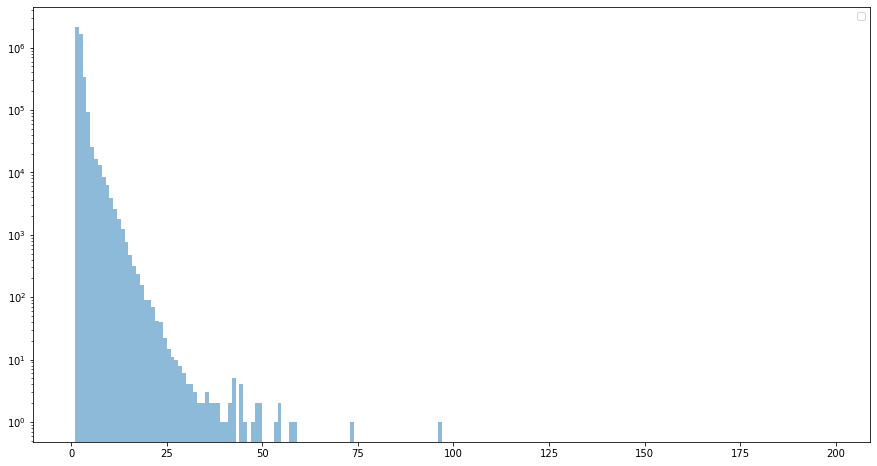

In [77]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 200, 1)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()

No handles with labels found to put in legend.


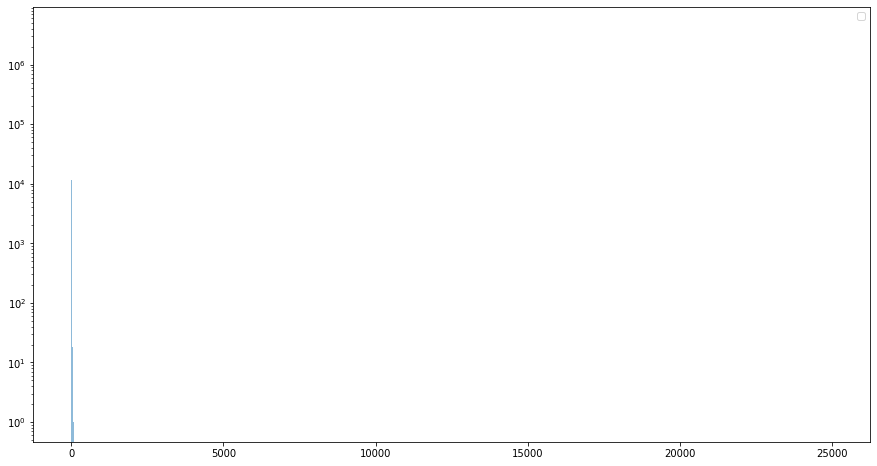

In [78]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 25000, 10)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()